In [1]:
using MAT
using Glob
using PyPlot
using Random
using Eirene
using Statistics
using DelimitedFiles

rng = MersenneTwister(1337);

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-12061743909317950536\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-9341726965528555945\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-12061743909317950536\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
function getdata(condition)
    filelist = glob("Pos_*.dat", string("simulation-data/", condition));
    filetodata = Dict{String, Array{Float64,2}}();
    sz = size(filelist)[1];
    for i in 1:sz
        filenamewext = split(filelist[i], '/')[3];
        filename = split(filenamewext, '.')[1];
        filenum = parse(Int, split(filename, '_')[2]);
        posarray = readdlm(filelist[i], ',', '\n');
        posx = [];
        posy = []
        for j in 1:size(posarray)[2]
            posarray[j] = chop(posarray[j]);
            xsign = 1;
            x_y = split(posarray[j], '-');
            if(x_y[1] == "")
                xsign = -1;
                x_y = deleteat!(x_y, 1);
            end
            x_plus_y = [];
            if(size(x_y)[1] == 1)
                x_plus_y = split(posarray[j], '+');
                x_plus_y = map(a->parse(Float64,a), x_plus_y);
                push!(posx, x_plus_y[1]);
                push!(posy, x_plus_y[2]);
            else
                x_y = map(a->parse(Float64,a), x_y);
                x_y[1] *= xsign;
                x_y[2] *= -1;
                push!(posx, x_y[1]);
                push!(posy, x_y[2]);
            end
        end
        positions = transpose(hcat(posx, posy));    
        push!(filetodata, filename => positions)
    end
    return filetodata;
end

getdata (generic function with 1 method)

In [3]:
function plot_dim0_barcode(dim0barcode_data)
    s = sortperm(dim0barcode_data[:,2]-dim0barcode_data[:,1], alg=MergeSort)
    dim0barcode_data = dim0barcode_data[s,:]
    bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    num_bars = size(bar_lengths)[1]
    delta_y = 0.1*num_bars
    figure(figsize=(8,8), dpi=600)
    y_cur = 0.0
    max_length = 0.0
    for len in bar_lengths
        if len != Inf
            if len > max_length
                    max_length = len
            end
            scatter(0.0, y_cur, s=2, color=:darkblue)
            scatter(len, y_cur, s=2, color=:darkblue)
            plot([0.0, len], [y_cur, y_cur], color=:darkblue)
            y_cur += delta_y
        end
    end
    scatter(0.0, y_cur, s=2, color=:darkblue)
    plot([0.0, max_length+0.2], [y_cur, y_cur], color=:darkblue)
    xlim(-0.01, max_length+0.1)
    ylim(-delta_y, y_cur+delta_y)
    yticks([])
    xlabel(L"$\epsilon$")
    ylabel(L"$H_0$")
end

function plot_persistence_diag(dim0barcode_data, dim1barcode_data)
    dim0_bar_lengths = dim0barcode_data[:,2] - dim0barcode_data[:,1]
    max_x = maximum(dim1barcode_data[:,1])
    max_y = 0.0
    figure(figsize=(8,8), dpi=600)
    for i in range(1, length=length(dim0_bar_lengths))
        len = dim0_bar_lengths[i]
        if len != Inf
            if len > max_y
                max_y = len
            end
            scatter(dim0barcode_data[i,1], dim0barcode_data[i,2], color=:darkblue, s=16)
        end
    end
    max_dim1_y = maximum(dim1barcode_data[:,2])
    max_y = maximum([max_y, max_dim1_y])
    scatter(dim1barcode_data[:,1], dim1barcode_data[:,2], color=:darkorange, s=16)
    max_plot_len = maximum([max_x, max_y])
    plot([0, max_plot_len+2], [0, max_plot_len+2], color=:black, "--")
    xlim([-0.1, max_x+0.5])
    ylim([-0.1, max_y+0.5])
    scatter(0.0, max_y+0.5-0.05, color=:darkblue, s=16)
    xlabel(L"$\epsilon$")
    ylabel(L"$\epsilon$")
    show()
end

function plot_removals(condition, removals)
    xypos = getdata(condition)["Pos_150000"]
    num_particles = size(xypos)[2]
    for num_removals in removals
        permutation = randperm(rng, num_particles)
        keep_idx = permutation[1:(num_particles-num_removals)]
        pos_tmp = xypos[:, keep_idx]
        pers_diag = eirene(pos_tmp, model="pc", maxdim=1)
        barcodedata_dim0 = barcode(pers_diag, dim=0)
        barcodedata_dim1 = barcode(pers_diag, dim=1)
        figure(figsize=(8,8), dpi=600)
        scatter(pos_tmp[1,:], pos_tmp[2,:], s=18)
        xticks([])
        yticks([])
        xlim([-11, 11])
        ylim([-11, 11])
        show()
        plot_dim0_barcode(barcodedata_dim0)
        plot_persistence_diag(barcodedata_dim0, barcodedata_dim1)
    end
end

plot_removals (generic function with 1 method)

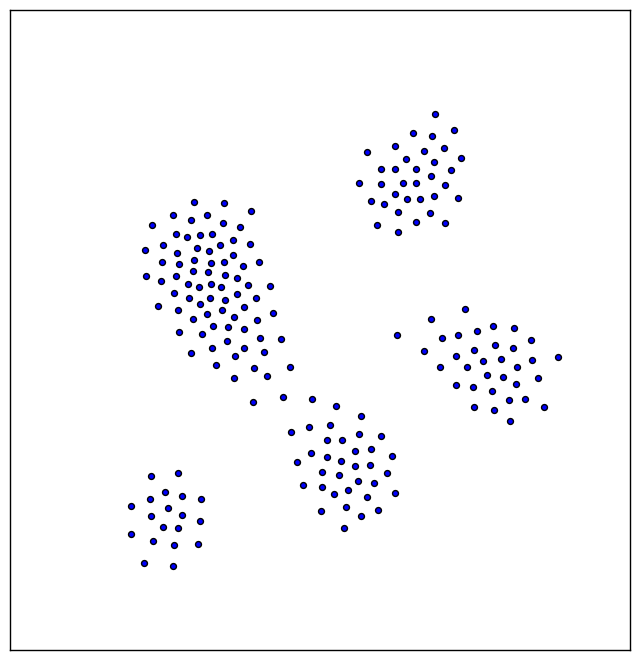

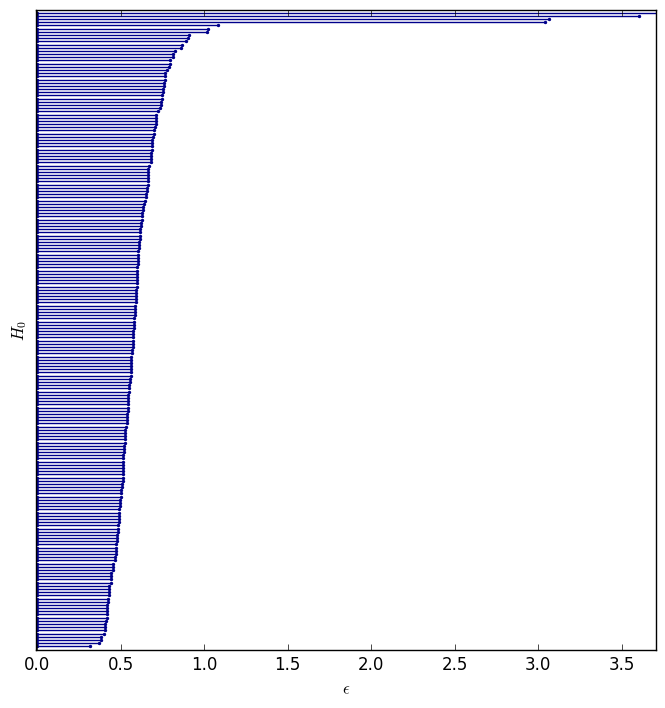

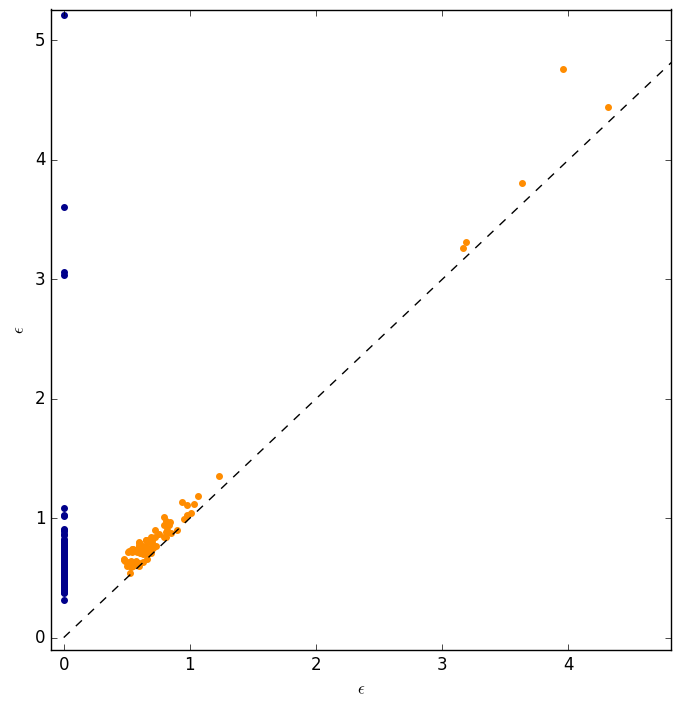

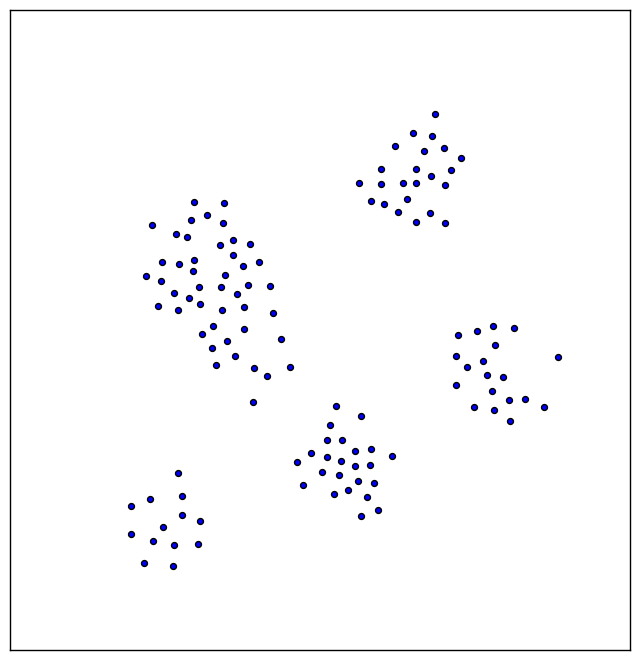

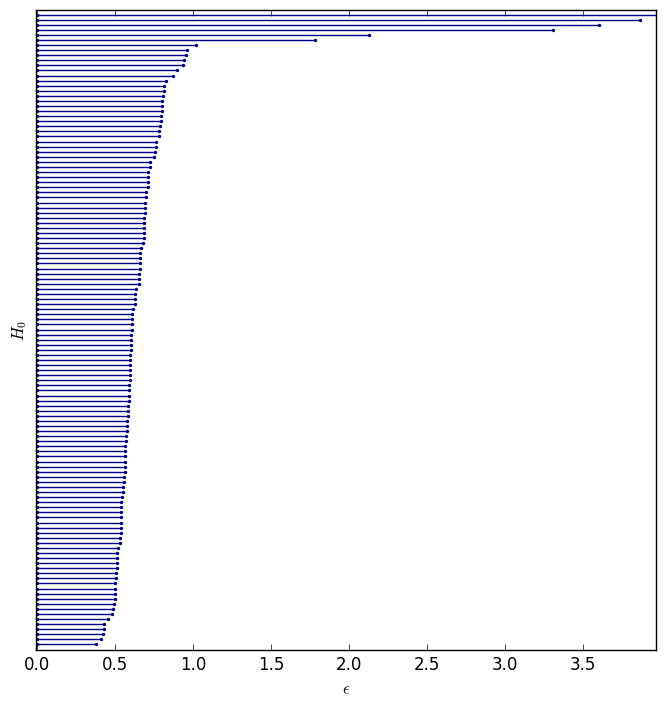

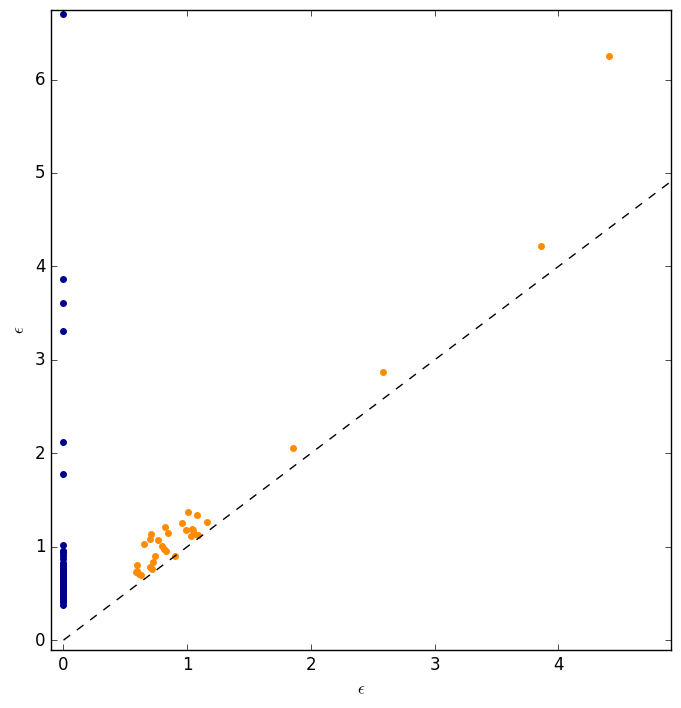

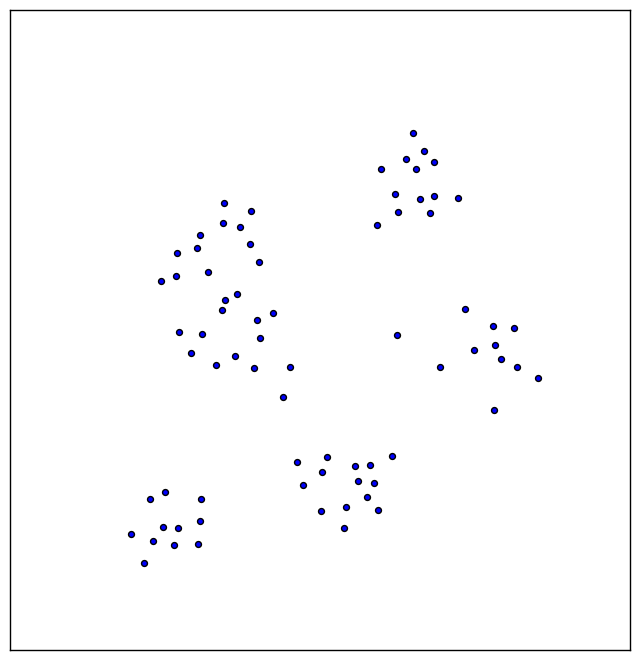

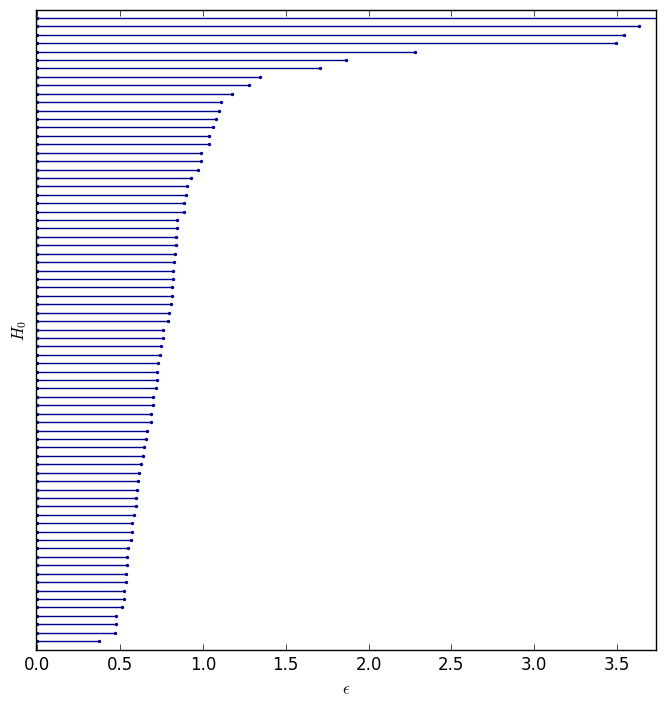

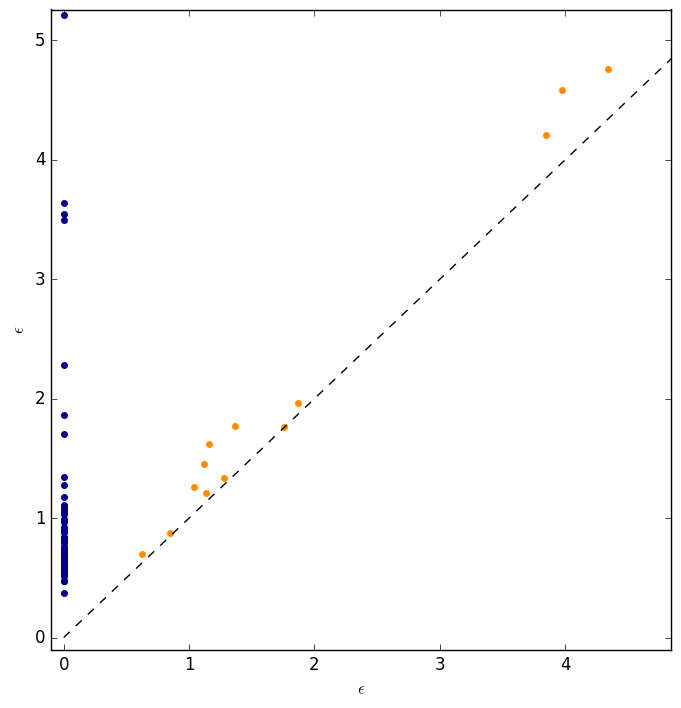

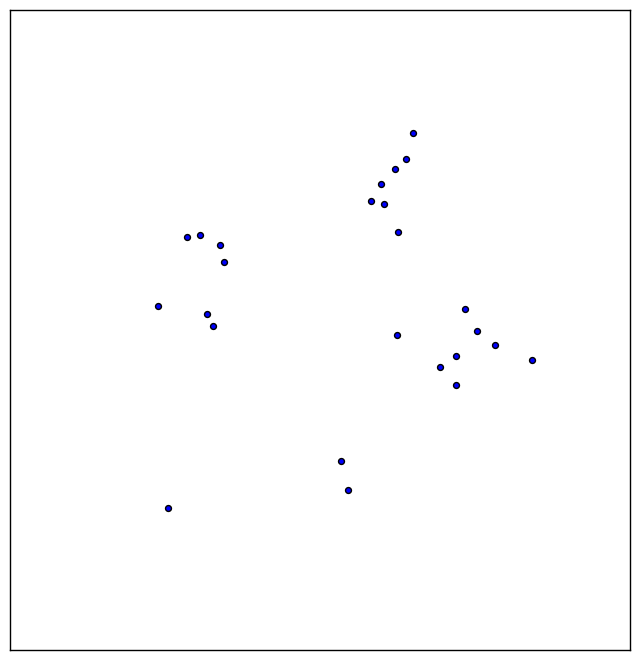

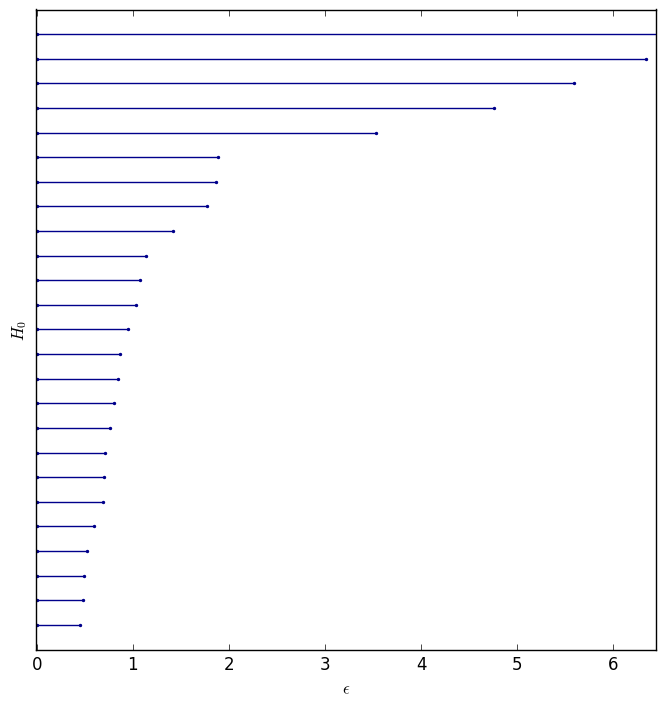

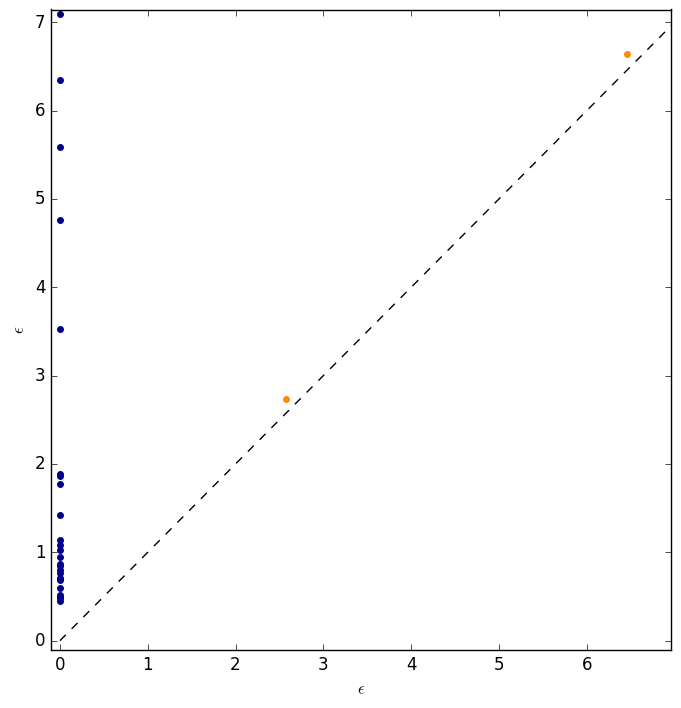

In [4]:
plot_removals("clustered", [0, 75, 125, 175])